In [1]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset , random_split
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from models import ConvNet
from dataset import RotationDataset
from helper_functions import train_convnet, evaluate_classifier,rotation_collate

2024-11-30 11:59:49.085987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 11:59:49.097699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732964389.111280  783749 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732964389.114884  783749 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 11:59:49.128385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# test hyperparamters:

In [3]:
ROTATION_NUMBER=4
CONV_BLOCKS=2
TRANSFER_LAYERS=1
assert TRANSFER_LAYERS<=CONV_BLOCKS
rotations=[i*360/(ROTATION_NUMBER) for i in range(ROTATION_NUMBER)]

## Datasets

In [5]:
dataset = datasets.MNIST(root='./data', 
                         train=True, 
                         download=True, 
                         transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', 
                        train=False, 
                        download=True, transform=transforms.ToTensor())

## Spliting Data

In [6]:
# Extract targets as a NumPy array
targets = np.array(dataset.targets)

# Select 10 indices for each class
indices = []
for digit in range(10):
    digit_indices = np.where(targets == digit)[0][:10]  # Take first 10 samples for each digit
    indices.extend(digit_indices)


supervised_dataset = Subset(dataset, indices)
unsupervised_dataset=Subset(dataset, np.setdiff1d(range(len(dataset)), indices))

print(f"Supervised dataset: {len(supervised_dataset)} samples")
print(f"Unsupervised dataset: {len(unsupervised_dataset)} samples")

Supervised dataset: 100 samples
Unsupervised dataset: 59900 samples


In [7]:
unsupervised_train_set, unsupervised_val_set = random_split(unsupervised_dataset, 
                                                            [0.9, 0.1])

print(f"Unsupervised training set: {len(unsupervised_train_set)} samples")
print(f"Unsupervised validation set: {len(unsupervised_val_set)} samples")


Unsupervised training set: 53910 samples
Unsupervised validation set: 5990 samples


## Visulaize

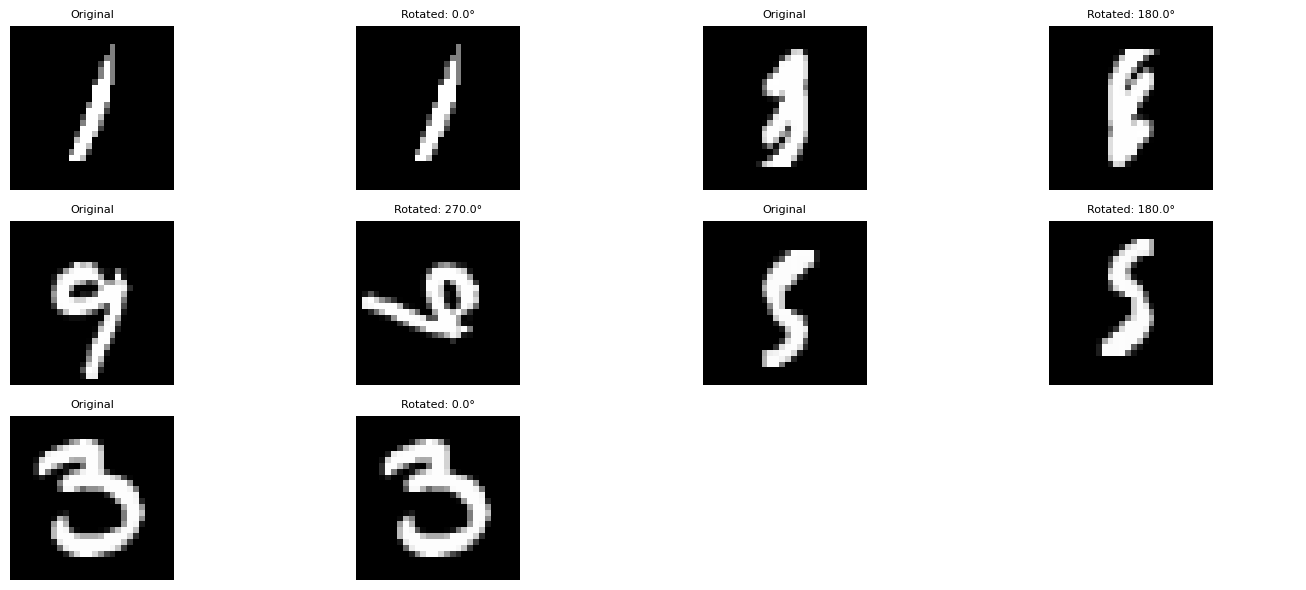

In [6]:
num_images = 5
num_cols = 2
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols * 2, figsize=(14, num_rows * 2))

for i in range(num_images):
    idx = torch.randint(0, len(unsupervised_train_set), (1,)).item()
    original_image, _ =unsupervised_train_set[idx]

    rotation_angle = random.choice(rotations)
    rotated_image = transforms.functional.rotate(original_image, rotation_angle)

    original_image = original_image.squeeze(0).numpy()
    rotated_image = rotated_image.squeeze(0).numpy()

    row, col = divmod(i, num_cols)
    original_col = col * 2
    rotated_col = col * 2 + 1

    axes[row, original_col].imshow(original_image, cmap='gray')
    axes[row, original_col].set_title("Original", fontsize=8)
    axes[row, original_col].axis('off')

    axes[row, rotated_col].imshow(rotated_image, cmap='gray')
    axes[row, rotated_col].set_title(f"Rotated: {rotation_angle}°", fontsize=8)
    axes[row, rotated_col].axis('off')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()



# Train rotnet

In [7]:
unsupervised_train_loader = DataLoader(RotationDataset(unsupervised_train_set,
                                                       rotations=rotations), 
                                       batch_size=256,
                                       shuffle=True,
                                       num_workers=8,
                                       persistent_workers=True,
                                       collate_fn=rotation_collate)

unsupervised_val_loader = DataLoader(RotationDataset(unsupervised_val_set,
                                                     rotations=rotations), 
                                     batch_size=256, 
                                     shuffle=False,
                                     num_workers=8,
                                     persistent_workers=True,
                                     collate_fn=rotation_collate)



In [13]:
rotnet = ConvNet(num_classes=len(rotations),num_blocks=CONV_BLOCKS).cuda()
optimizer = torch.optim.Adam(rotnet.parameters(), lr=0.001,weight_decay=0.001)
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

train_convnet(rotnet, 
                 unsupervised_train_loader, 
                 unsupervised_val_loader,
                 nn.CrossEntropyLoss(),
                 optimizer,
                 learning_rate_scheduler, 
                 num_epochs=100,
                 filename=f'rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth')

    

Epoch 1/100 [Training]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 1/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 30.55it/s]


Epoch [1/100] - 
Train Loss: 0.9704, Train Accuracy: 62.20%, 
Validation Loss: 0.8391, Validation Accuracy: 69.44%



Epoch 2/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 37.69it/s]


Epoch [2/100] - 
Train Loss: 0.7212, Train Accuracy: 74.28%, 
Validation Loss: 0.6779, Validation Accuracy: 74.24%



Epoch 3/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 40.05it/s]


Epoch [3/100] - 
Train Loss: 0.5902, Train Accuracy: 78.72%, 
Validation Loss: 0.5734, Validation Accuracy: 76.89%



Epoch 4/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 42.06it/s]


Epoch [4/100] - 
Train Loss: 0.5152, Train Accuracy: 81.78%, 
Validation Loss: 0.4914, Validation Accuracy: 82.16%



Epoch 5/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 26.53it/s]


Epoch [5/100] - 
Train Loss: 0.4666, Train Accuracy: 83.81%, 
Validation Loss: 0.4721, Validation Accuracy: 83.60%



Epoch 6/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.63it/s]


Epoch [6/100] - 
Train Loss: 0.4324, Train Accuracy: 85.32%, 
Validation Loss: 0.4500, Validation Accuracy: 84.11%



Epoch 7/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 30.01it/s]


Epoch [7/100] - 
Train Loss: 0.4075, Train Accuracy: 86.35%, 
Validation Loss: 0.4248, Validation Accuracy: 84.70%



Epoch 8/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.57it/s]


Epoch [8/100] - 
Train Loss: 0.3885, Train Accuracy: 87.07%, 
Validation Loss: 0.3905, Validation Accuracy: 86.76%



Epoch 9/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 38.26it/s]


Epoch [9/100] - 
Train Loss: 0.3730, Train Accuracy: 87.75%, 
Validation Loss: 0.4018, Validation Accuracy: 85.41%



Epoch 10/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 38.05it/s]


Epoch [10/100] - 
Train Loss: 0.3597, Train Accuracy: 88.33%, 
Validation Loss: 0.4115, Validation Accuracy: 84.38%



Epoch 11/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.48it/s]


Epoch [11/100] - 
Train Loss: 0.3491, Train Accuracy: 88.64%, 
Validation Loss: 0.4305, Validation Accuracy: 82.34%



Epoch 12/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.91it/s]


Epoch [12/100] - 
Train Loss: 0.3414, Train Accuracy: 88.95%, 
Validation Loss: 0.3758, Validation Accuracy: 86.29%



Epoch 13/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 38.72it/s]


Epoch [13/100] - 
Train Loss: 0.3321, Train Accuracy: 89.42%, 
Validation Loss: 0.3494, Validation Accuracy: 87.95%



Epoch 14/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 38.14it/s]


Epoch [14/100] - 
Train Loss: 0.3240, Train Accuracy: 89.69%, 
Validation Loss: 0.3603, Validation Accuracy: 86.96%



Epoch 15/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.74it/s]


Epoch [15/100] - 
Train Loss: 0.3181, Train Accuracy: 89.93%, 
Validation Loss: 0.3760, Validation Accuracy: 85.32%



Epoch 16/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.15it/s]


Epoch [16/100] - 
Train Loss: 0.3141, Train Accuracy: 90.08%, 
Validation Loss: 0.3950, Validation Accuracy: 84.30%



Epoch 17/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.40it/s]


Epoch [17/100] - 
Train Loss: 0.3068, Train Accuracy: 90.39%, 
Validation Loss: 0.3390, Validation Accuracy: 87.98%



Epoch 18/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 37.20it/s]


Epoch [18/100] - 
Train Loss: 0.3038, Train Accuracy: 90.49%, 
Validation Loss: 0.3188, Validation Accuracy: 89.24%



Epoch 19/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.30it/s]


Epoch [19/100] - 
Train Loss: 0.2997, Train Accuracy: 90.59%, 
Validation Loss: 0.3285, Validation Accuracy: 88.63%



Epoch 20/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.37it/s]


Epoch [20/100] - 
Train Loss: 0.2965, Train Accuracy: 90.73%, 
Validation Loss: 0.3082, Validation Accuracy: 90.17%



Epoch 21/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.90it/s]


Epoch [21/100] - 
Train Loss: 0.2923, Train Accuracy: 90.87%, 
Validation Loss: 0.3246, Validation Accuracy: 88.53%



Epoch 22/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.85it/s]


Epoch [22/100] - 
Train Loss: 0.2889, Train Accuracy: 91.05%, 
Validation Loss: 0.3184, Validation Accuracy: 89.23%



Epoch 23/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.68it/s]


Epoch [23/100] - 
Train Loss: 0.2853, Train Accuracy: 91.24%, 
Validation Loss: 0.3429, Validation Accuracy: 87.15%



Epoch 24/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.54it/s]


Epoch [24/100] - 
Train Loss: 0.2839, Train Accuracy: 91.25%, 
Validation Loss: 0.3315, Validation Accuracy: 87.78%



Epoch 25/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.66it/s]


Epoch [25/100] - 
Train Loss: 0.2817, Train Accuracy: 91.26%, 
Validation Loss: 0.3074, Validation Accuracy: 89.74%



Epoch 26/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.79it/s]


Epoch [26/100] - 
Train Loss: 0.2787, Train Accuracy: 91.42%, 
Validation Loss: 0.4594, Validation Accuracy: 79.50%



Epoch 27/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 31.72it/s]


Epoch [27/100] - 
Train Loss: 0.2770, Train Accuracy: 91.47%, 
Validation Loss: 0.3421, Validation Accuracy: 87.11%



Epoch 28/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.24it/s]


Epoch [28/100] - 
Train Loss: 0.2750, Train Accuracy: 91.53%, 
Validation Loss: 0.2849, Validation Accuracy: 90.93%



Epoch 29/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.44it/s]


Epoch [29/100] - 
Train Loss: 0.2719, Train Accuracy: 91.66%, 
Validation Loss: 0.3082, Validation Accuracy: 89.30%



Epoch 30/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.42it/s]


Epoch [30/100] - 
Train Loss: 0.2711, Train Accuracy: 91.72%, 
Validation Loss: 0.2835, Validation Accuracy: 90.96%



Epoch 31/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.14it/s]


Epoch [31/100] - 
Train Loss: 0.2694, Train Accuracy: 91.77%, 
Validation Loss: 0.2880, Validation Accuracy: 90.93%



Epoch 32/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.52it/s]


Epoch [32/100] - 
Train Loss: 0.2685, Train Accuracy: 91.78%, 
Validation Loss: 0.2958, Validation Accuracy: 89.87%



Epoch 33/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 37.49it/s]


Epoch [33/100] - 
Train Loss: 0.2659, Train Accuracy: 91.92%, 
Validation Loss: 0.3771, Validation Accuracy: 84.38%



Epoch 34/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.13it/s]


Epoch [34/100] - 
Train Loss: 0.2652, Train Accuracy: 91.87%, 
Validation Loss: 0.3004, Validation Accuracy: 89.90%



Epoch 35/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.42it/s]


Epoch [35/100] - 
Train Loss: 0.2637, Train Accuracy: 92.01%, 
Validation Loss: 0.3447, Validation Accuracy: 86.53%



Epoch 36/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.17it/s]


Epoch [36/100] - 
Train Loss: 0.2633, Train Accuracy: 91.99%, 
Validation Loss: 0.3343, Validation Accuracy: 87.36%



Epoch 37/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.00it/s]


Epoch [37/100] - 
Train Loss: 0.2610, Train Accuracy: 92.10%, 
Validation Loss: 0.2936, Validation Accuracy: 90.61%



Epoch 38/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.42it/s]


Epoch [38/100] - 
Train Loss: 0.2613, Train Accuracy: 92.07%, 
Validation Loss: 0.3111, Validation Accuracy: 89.80%



Epoch 39/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.81it/s]


Epoch [39/100] - 
Train Loss: 0.2589, Train Accuracy: 92.18%, 
Validation Loss: 0.2847, Validation Accuracy: 90.49%



Epoch 40/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.07it/s]


Epoch [40/100] - 
Train Loss: 0.2591, Train Accuracy: 92.14%, 
Validation Loss: 0.3676, Validation Accuracy: 85.18%



Epoch 41/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.68it/s]


Epoch [41/100] - 
Train Loss: 0.2579, Train Accuracy: 92.24%, 
Validation Loss: 0.2889, Validation Accuracy: 90.03%



Epoch 42/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.08it/s]


Epoch [42/100] - 
Train Loss: 0.2566, Train Accuracy: 92.24%, 
Validation Loss: 0.2749, Validation Accuracy: 90.98%



Epoch 43/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.52it/s]


Epoch [43/100] - 
Train Loss: 0.2552, Train Accuracy: 92.39%, 
Validation Loss: 0.2804, Validation Accuracy: 90.67%



Epoch 44/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.06it/s]


Epoch [44/100] - 
Train Loss: 0.2543, Train Accuracy: 92.40%, 
Validation Loss: 0.3662, Validation Accuracy: 85.44%



Epoch 45/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.99it/s]


Epoch [45/100] - 
Train Loss: 0.2539, Train Accuracy: 92.36%, 
Validation Loss: 0.3776, Validation Accuracy: 84.63%



Epoch 46/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.96it/s]


Epoch [46/100] - 
Train Loss: 0.2533, Train Accuracy: 92.44%, 
Validation Loss: 0.3229, Validation Accuracy: 87.88%



Epoch 47/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.22it/s]


Epoch [47/100] - 
Train Loss: 0.2538, Train Accuracy: 92.38%, 
Validation Loss: 0.3618, Validation Accuracy: 85.70%



Epoch 48/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.82it/s]


Epoch [48/100] - 
Train Loss: 0.2527, Train Accuracy: 92.36%, 
Validation Loss: 0.2723, Validation Accuracy: 91.29%



Epoch 49/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 37.92it/s]


Epoch [49/100] - 
Train Loss: 0.2517, Train Accuracy: 92.45%, 
Validation Loss: 0.2819, Validation Accuracy: 90.63%



Epoch 50/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.97it/s]


Epoch [50/100] - 
Train Loss: 0.2495, Train Accuracy: 92.62%, 
Validation Loss: 0.2957, Validation Accuracy: 89.55%



Epoch 51/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.65it/s]


Epoch [51/100] - 
Train Loss: 0.2419, Train Accuracy: 92.96%, 
Validation Loss: 0.3014, Validation Accuracy: 88.94%



Epoch 52/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.73it/s]


Epoch [52/100] - 
Train Loss: 0.2417, Train Accuracy: 92.99%, 
Validation Loss: 0.2683, Validation Accuracy: 91.32%



Epoch 53/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.55it/s]


Epoch [53/100] - 
Train Loss: 0.2415, Train Accuracy: 92.98%, 
Validation Loss: 0.2603, Validation Accuracy: 91.73%



Epoch 54/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.03it/s]


Epoch [54/100] - 
Train Loss: 0.2414, Train Accuracy: 92.99%, 
Validation Loss: 0.2604, Validation Accuracy: 91.72%



Epoch 55/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.56it/s]


Epoch [55/100] - 
Train Loss: 0.2415, Train Accuracy: 92.96%, 
Validation Loss: 0.2717, Validation Accuracy: 91.41%



Epoch 56/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.49it/s]


Epoch [56/100] - 
Train Loss: 0.2404, Train Accuracy: 93.02%, 
Validation Loss: 0.2668, Validation Accuracy: 91.21%



Epoch 57/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.21it/s]


Epoch [57/100] - 
Train Loss: 0.2407, Train Accuracy: 93.00%, 
Validation Loss: 0.2668, Validation Accuracy: 91.23%



Epoch 58/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.32it/s]


Epoch [58/100] - 
Train Loss: 0.2401, Train Accuracy: 92.99%, 
Validation Loss: 0.2712, Validation Accuracy: 91.11%



Epoch 59/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.92it/s]


Epoch [59/100] - 
Train Loss: 0.2397, Train Accuracy: 93.03%, 
Validation Loss: 0.2681, Validation Accuracy: 91.18%



Epoch 60/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.88it/s]


Epoch [60/100] - 
Train Loss: 0.2398, Train Accuracy: 93.06%, 
Validation Loss: 0.3497, Validation Accuracy: 86.06%



Epoch 61/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.85it/s]


Epoch [61/100] - 
Train Loss: 0.2395, Train Accuracy: 93.03%, 
Validation Loss: 0.3007, Validation Accuracy: 88.97%



Epoch 62/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.28it/s]


Epoch [62/100] - 
Train Loss: 0.2393, Train Accuracy: 93.04%, 
Validation Loss: 0.3251, Validation Accuracy: 87.23%



Epoch 63/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.99it/s]


Epoch [63/100] - 
Train Loss: 0.2384, Train Accuracy: 93.09%, 
Validation Loss: 0.2631, Validation Accuracy: 91.46%



Epoch 64/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.00it/s]


Epoch [64/100] - 
Train Loss: 0.2379, Train Accuracy: 93.16%, 
Validation Loss: 0.2694, Validation Accuracy: 91.01%



Epoch 65/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.61it/s]


Epoch [65/100] - 
Train Loss: 0.2376, Train Accuracy: 93.12%, 
Validation Loss: 0.2762, Validation Accuracy: 90.74%



Epoch 66/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.85it/s]


Epoch [66/100] - 
Train Loss: 0.2375, Train Accuracy: 93.08%, 
Validation Loss: 0.2668, Validation Accuracy: 91.23%



Epoch 67/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.40it/s]


Epoch [67/100] - 
Train Loss: 0.2374, Train Accuracy: 93.12%, 
Validation Loss: 0.2959, Validation Accuracy: 89.27%



Epoch 68/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.62it/s]


Epoch [68/100] - 
Train Loss: 0.2365, Train Accuracy: 93.15%, 
Validation Loss: 0.2598, Validation Accuracy: 91.71%



Epoch 69/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.51it/s]


Epoch [69/100] - 
Train Loss: 0.2364, Train Accuracy: 93.17%, 
Validation Loss: 0.2631, Validation Accuracy: 91.55%



Epoch 70/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.05it/s]


Epoch [70/100] - 
Train Loss: 0.2364, Train Accuracy: 93.17%, 
Validation Loss: 0.2652, Validation Accuracy: 91.28%



Epoch 71/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.30it/s]


Epoch [71/100] - 
Train Loss: 0.2354, Train Accuracy: 93.20%, 
Validation Loss: 0.2748, Validation Accuracy: 90.76%



Epoch 72/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.14it/s]


Epoch [72/100] - 
Train Loss: 0.2360, Train Accuracy: 93.20%, 
Validation Loss: 0.2658, Validation Accuracy: 91.16%



Epoch 73/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.12it/s]


Epoch [73/100] - 
Train Loss: 0.2355, Train Accuracy: 93.21%, 
Validation Loss: 0.2620, Validation Accuracy: 91.51%



Epoch 74/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 31.67it/s]


Epoch [74/100] - 
Train Loss: 0.2353, Train Accuracy: 93.20%, 
Validation Loss: 0.2702, Validation Accuracy: 90.86%



Epoch 75/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.99it/s]


Epoch [75/100] - 
Train Loss: 0.2349, Train Accuracy: 93.27%, 
Validation Loss: 0.3059, Validation Accuracy: 88.64%



Epoch 76/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.44it/s]


Epoch [76/100] - 
Train Loss: 0.2352, Train Accuracy: 93.22%, 
Validation Loss: 0.3203, Validation Accuracy: 87.92%



Epoch 77/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.11it/s]


Epoch [77/100] - 
Train Loss: 0.2342, Train Accuracy: 93.27%, 
Validation Loss: 0.2988, Validation Accuracy: 88.93%



Epoch 78/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.76it/s]


Epoch [78/100] - 
Train Loss: 0.2339, Train Accuracy: 93.29%, 
Validation Loss: 0.2536, Validation Accuracy: 91.90%



Epoch 79/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.67it/s]


Epoch [79/100] - 
Train Loss: 0.2345, Train Accuracy: 93.28%, 
Validation Loss: 0.3158, Validation Accuracy: 88.46%



Epoch 80/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.57it/s]


Epoch [80/100] - 
Train Loss: 0.2334, Train Accuracy: 93.32%, 
Validation Loss: 0.2784, Validation Accuracy: 90.17%



Epoch 81/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.86it/s]


Epoch [81/100] - 
Train Loss: 0.2337, Train Accuracy: 93.26%, 
Validation Loss: 0.2896, Validation Accuracy: 89.67%



Epoch 82/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.65it/s]


Epoch [82/100] - 
Train Loss: 0.2332, Train Accuracy: 93.30%, 
Validation Loss: 0.2589, Validation Accuracy: 91.86%



Epoch 83/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 37.23it/s]


Epoch [83/100] - 
Train Loss: 0.2328, Train Accuracy: 93.31%, 
Validation Loss: 0.2518, Validation Accuracy: 92.14%



Epoch 84/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.44it/s]


Epoch [84/100] - 
Train Loss: 0.2328, Train Accuracy: 93.29%, 
Validation Loss: 0.2630, Validation Accuracy: 91.41%



Epoch 85/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.70it/s]


Epoch [85/100] - 
Train Loss: 0.2325, Train Accuracy: 93.33%, 
Validation Loss: 0.2565, Validation Accuracy: 91.72%



Epoch 86/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.92it/s]


Epoch [86/100] - 
Train Loss: 0.2327, Train Accuracy: 93.31%, 
Validation Loss: 0.2681, Validation Accuracy: 91.03%



Epoch 87/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.81it/s]


Epoch [87/100] - 
Train Loss: 0.2321, Train Accuracy: 93.37%, 
Validation Loss: 0.2574, Validation Accuracy: 91.72%



Epoch 88/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.97it/s]


Epoch [88/100] - 
Train Loss: 0.2321, Train Accuracy: 93.33%, 
Validation Loss: 0.2829, Validation Accuracy: 89.97%



Epoch 89/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.74it/s]


Epoch [89/100] - 
Train Loss: 0.2313, Train Accuracy: 93.40%, 
Validation Loss: 0.2511, Validation Accuracy: 91.94%



Epoch 90/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.68it/s]


Epoch [90/100] - 
Train Loss: 0.2313, Train Accuracy: 93.37%, 
Validation Loss: 0.2765, Validation Accuracy: 90.58%



Epoch 91/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.07it/s]


Epoch [91/100] - 
Train Loss: 0.2311, Train Accuracy: 93.43%, 
Validation Loss: 0.2505, Validation Accuracy: 92.14%



Epoch 92/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.04it/s]


Epoch [92/100] - 
Train Loss: 0.2314, Train Accuracy: 93.36%, 
Validation Loss: 0.2614, Validation Accuracy: 91.49%



Epoch 93/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 36.32it/s]


Epoch [93/100] - 
Train Loss: 0.2315, Train Accuracy: 93.37%, 
Validation Loss: 0.2637, Validation Accuracy: 91.26%



Epoch 94/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 35.45it/s]


Epoch [94/100] - 
Train Loss: 0.2306, Train Accuracy: 93.42%, 
Validation Loss: 0.2563, Validation Accuracy: 92.05%



Epoch 95/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.65it/s]


Epoch [95/100] - 
Train Loss: 0.2307, Train Accuracy: 93.41%, 
Validation Loss: 0.2964, Validation Accuracy: 88.83%



Epoch 96/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.81it/s]


Epoch [96/100] - 
Train Loss: 0.2309, Train Accuracy: 93.39%, 
Validation Loss: 0.2626, Validation Accuracy: 91.34%



Epoch 97/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.19it/s]


Epoch [97/100] - 
Train Loss: 0.2306, Train Accuracy: 93.43%, 
Validation Loss: 0.2572, Validation Accuracy: 91.44%



Epoch 98/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 34.24it/s]


Epoch [98/100] - 
Train Loss: 0.2305, Train Accuracy: 93.40%, 
Validation Loss: 0.2846, Validation Accuracy: 90.11%



Epoch 99/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 33.91it/s]


Epoch [99/100] - 
Train Loss: 0.2308, Train Accuracy: 93.38%, 
Validation Loss: 0.3134, Validation Accuracy: 88.09%



Epoch 100/100 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 32.44it/s]

Epoch [100/100] - 
Train Loss: 0.2303, Train Accuracy: 93.40%, 
Validation Loss: 0.2469, Validation Accuracy: 92.45%



In [14]:
best_model=ConvNet(num_classes=len(rotations),num_blocks=CONV_BLOCKS).cuda()
best_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth'))    

/tmp/ipykernel_671032/3641225631.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pt

<All keys matched successfully>

In [15]:
evaluate_classifier(best_model, unsupervised_val_loader)

Test Accuracy: 92.45%


## Transfer Encoder

#### Load RotNet model

In [8]:
rotnet_model=ConvNet(num_classes=len(rotations),num_blocks=CONV_BLOCKS).cuda()
rotnet_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth'))
rotnet_model=rotnet_model.cuda()

/tmp/ipykernel_783749/4161198983.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotnet_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.

### Create MNIST model

In [9]:
MNIST_model = ConvNet(num_classes=10,num_blocks=TRANSFER_LAYERS+1).cuda()

In [10]:
MNIST_model

ConvNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=1)
  (classification_head): Linear(in_features=64, out_features=10, bias=True)
)

#### Transfer Layers

In [11]:
MNIST_model.transfer_layers(rotnet_model, num_transfer_blocks=TRANSFER_LAYERS)

Transferred 1 blocks from source model to target model.


In [12]:
MNIST_model

ConvNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=1)
  (classification_head): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
supervised_train_loader = DataLoader(supervised_dataset, 
                                     batch_size=8, 
                                     shuffle=True,
                                     num_workers=4,
                                     persistent_workers=True)
supervised_val_loader = DataLoader(test_dataset, 
                                   batch_size=8, 
                                   shuffle=False,
                                   num_workers=4,
                                   persistent_workers=True)

optimizer=torch.optim.Adam(MNIST_model.parameters(),lr=0.01,weight_decay=0.001)
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

train_convnet(MNIST_model, 
                 supervised_train_loader, 
                 supervised_val_loader,
                 nn.CrossEntropyLoss(),
                 optimizer,
                 learning_rate_scheduler, 
                 num_epochs=500,
                 num_frozen_blocks=TRANSFER_LAYERS,
                 filename=f'rot_mnist_model_{ROTATION_NUMBER}_{CONV_BLOCKS}_{TRANSFER_LAYERS}.pth')

1
Freezing the first 1 layers...
[Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)]
Freezing Sequential


Epoch 1/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 741.45it/s]


Epoch [1/500] - 
Train Loss: 2.4800, Train Accuracy: 12.00%, 
Validation Loss: 2.2923, Validation Accuracy: 9.25%



Epoch 2/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 854.97it/s]


Epoch [2/500] - 
Train Loss: 2.2816, Train Accuracy: 12.00%, 
Validation Loss: 2.2516, Validation Accuracy: 17.44%



Epoch 3/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 836.22it/s]


Epoch [3/500] - 
Train Loss: 2.1774, Train Accuracy: 17.00%, 
Validation Loss: 2.1757, Validation Accuracy: 18.07%



Epoch 4/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 871.93it/s]


Epoch [4/500] - 
Train Loss: 2.0987, Train Accuracy: 30.00%, 
Validation Loss: 2.1457, Validation Accuracy: 20.05%



Epoch 5/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 823.83it/s]


Epoch [5/500] - 
Train Loss: 2.0116, Train Accuracy: 27.00%, 
Validation Loss: 2.0199, Validation Accuracy: 28.37%



Epoch 6/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 865.70it/s]


Epoch [6/500] - 
Train Loss: 1.9127, Train Accuracy: 35.00%, 
Validation Loss: 1.9556, Validation Accuracy: 31.21%



Epoch 7/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 865.97it/s]


Epoch [7/500] - 
Train Loss: 1.8028, Train Accuracy: 42.00%, 
Validation Loss: 1.9322, Validation Accuracy: 34.09%



Epoch 8/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 842.90it/s]


Epoch [8/500] - 
Train Loss: 1.7537, Train Accuracy: 45.00%, 
Validation Loss: 1.8888, Validation Accuracy: 27.02%



Epoch 9/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 857.62it/s]


Epoch [9/500] - 
Train Loss: 1.7332, Train Accuracy: 40.00%, 
Validation Loss: 2.2850, Validation Accuracy: 20.20%



Epoch 10/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 831.87it/s]


Epoch [10/500] - 
Train Loss: 1.7344, Train Accuracy: 43.00%, 
Validation Loss: 1.8245, Validation Accuracy: 31.94%



Epoch 11/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 855.51it/s]


Epoch [11/500] - 
Train Loss: 1.6133, Train Accuracy: 51.00%, 
Validation Loss: 1.7788, Validation Accuracy: 36.26%



Epoch 12/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 798.64it/s]


Epoch [12/500] - 
Train Loss: 1.6529, Train Accuracy: 42.00%, 
Validation Loss: 1.8509, Validation Accuracy: 29.88%



Epoch 13/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 851.55it/s]


Epoch [13/500] - 
Train Loss: 1.5366, Train Accuracy: 41.00%, 
Validation Loss: 1.7230, Validation Accuracy: 38.42%



Epoch 14/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 829.24it/s]


Epoch [14/500] - 
Train Loss: 1.4794, Train Accuracy: 51.00%, 
Validation Loss: 1.6988, Validation Accuracy: 37.38%



Epoch 15/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 838.45it/s]


Epoch [15/500] - 
Train Loss: 1.4928, Train Accuracy: 48.00%, 
Validation Loss: 1.8496, Validation Accuracy: 34.22%



Epoch 16/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 840.24it/s]


Epoch [16/500] - 
Train Loss: 1.5031, Train Accuracy: 50.00%, 
Validation Loss: 1.7615, Validation Accuracy: 32.57%



Epoch 17/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 857.69it/s]


Epoch [17/500] - 
Train Loss: 1.4144, Train Accuracy: 52.00%, 
Validation Loss: 1.6180, Validation Accuracy: 40.89%



Epoch 18/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 827.34it/s]


Epoch [18/500] - 
Train Loss: 1.3641, Train Accuracy: 53.00%, 
Validation Loss: 2.0653, Validation Accuracy: 26.04%



Epoch 19/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 808.91it/s]


Epoch [19/500] - 
Train Loss: 1.3900, Train Accuracy: 54.00%, 
Validation Loss: 2.1766, Validation Accuracy: 30.09%



Epoch 20/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 846.18it/s]


Epoch [20/500] - 
Train Loss: 1.2378, Train Accuracy: 59.00%, 
Validation Loss: 1.5897, Validation Accuracy: 40.45%



Epoch 21/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 844.62it/s]


Epoch [21/500] - 
Train Loss: 1.2473, Train Accuracy: 54.00%, 
Validation Loss: 1.7753, Validation Accuracy: 35.11%



Epoch 22/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 838.93it/s]


Epoch [22/500] - 
Train Loss: 1.3256, Train Accuracy: 61.00%, 
Validation Loss: 1.8247, Validation Accuracy: 35.21%



Epoch 23/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 801.26it/s]


Epoch [23/500] - 
Train Loss: 1.1307, Train Accuracy: 62.00%, 
Validation Loss: 1.7978, Validation Accuracy: 38.54%



Epoch 24/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 828.37it/s]


Epoch [24/500] - 
Train Loss: 1.2344, Train Accuracy: 57.00%, 
Validation Loss: 1.7936, Validation Accuracy: 32.53%



Epoch 25/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 810.05it/s]


Epoch [25/500] - 
Train Loss: 1.1413, Train Accuracy: 60.00%, 
Validation Loss: 1.8714, Validation Accuracy: 31.98%



Epoch 26/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 801.53it/s]


Epoch [26/500] - 
Train Loss: 1.2002, Train Accuracy: 57.00%, 
Validation Loss: 1.8981, Validation Accuracy: 32.36%



Epoch 27/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 798.06it/s]


Epoch [27/500] - 
Train Loss: 1.2987, Train Accuracy: 64.00%, 
Validation Loss: 2.3597, Validation Accuracy: 27.15%



Epoch 28/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 811.25it/s]


Epoch [28/500] - 
Train Loss: 1.2389, Train Accuracy: 57.00%, 
Validation Loss: 1.6740, Validation Accuracy: 39.04%



Epoch 29/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 852.75it/s]


Epoch [29/500] - 
Train Loss: 1.3014, Train Accuracy: 62.00%, 
Validation Loss: 2.1587, Validation Accuracy: 33.25%



Epoch 30/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 810.34it/s]


Epoch [30/500] - 
Train Loss: 1.3137, Train Accuracy: 55.00%, 
Validation Loss: 1.9225, Validation Accuracy: 33.64%



Epoch 31/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 857.99it/s]


Epoch [31/500] - 
Train Loss: 1.1806, Train Accuracy: 59.00%, 
Validation Loss: 1.6592, Validation Accuracy: 36.72%



Epoch 32/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 729.30it/s]


Epoch [32/500] - 
Train Loss: 0.9941, Train Accuracy: 75.00%, 
Validation Loss: 1.5982, Validation Accuracy: 40.54%



Epoch 33/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 824.56it/s]


Epoch [33/500] - 
Train Loss: 1.0633, Train Accuracy: 60.00%, 
Validation Loss: 1.4792, Validation Accuracy: 48.70%



Epoch 34/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 807.66it/s]


Epoch [34/500] - 
Train Loss: 0.9950, Train Accuracy: 73.00%, 
Validation Loss: 1.7418, Validation Accuracy: 39.27%



Epoch 35/500 [Validation]: 100%|██████████| 1250/1250 [00:02<00:00, 607.76it/s]


Epoch [35/500] - 
Train Loss: 0.9027, Train Accuracy: 75.00%, 
Validation Loss: 1.5793, Validation Accuracy: 40.76%



Epoch 36/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 815.63it/s]


Epoch [36/500] - 
Train Loss: 0.9545, Train Accuracy: 75.00%, 
Validation Loss: 1.7150, Validation Accuracy: 37.01%



Epoch 37/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 802.14it/s]


Epoch [37/500] - 
Train Loss: 0.9793, Train Accuracy: 70.00%, 
Validation Loss: 1.8703, Validation Accuracy: 38.06%



Epoch 38/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 762.55it/s]


Epoch [38/500] - 
Train Loss: 0.9901, Train Accuracy: 71.00%, 
Validation Loss: 1.9463, Validation Accuracy: 34.04%



Epoch 39/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 777.83it/s]


Epoch [39/500] - 
Train Loss: 0.9688, Train Accuracy: 75.00%, 
Validation Loss: 1.8402, Validation Accuracy: 40.29%



Epoch 40/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 753.41it/s]


Epoch [40/500] - 
Train Loss: 0.9072, Train Accuracy: 72.00%, 
Validation Loss: 1.8798, Validation Accuracy: 31.98%



Epoch 41/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 829.61it/s]


Epoch [41/500] - 
Train Loss: 0.7889, Train Accuracy: 76.00%, 
Validation Loss: 2.3360, Validation Accuracy: 32.71%



Epoch 42/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 664.00it/s]


Epoch [42/500] - 
Train Loss: 0.8193, Train Accuracy: 76.00%, 
Validation Loss: 2.7490, Validation Accuracy: 35.14%



Epoch 43/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 832.30it/s]


Epoch [43/500] - 
Train Loss: 0.9108, Train Accuracy: 83.00%, 
Validation Loss: 2.7933, Validation Accuracy: 28.86%



Epoch 44/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 796.86it/s]


Epoch [44/500] - 
Train Loss: 0.9601, Train Accuracy: 65.00%, 
Validation Loss: 2.2362, Validation Accuracy: 32.81%



Epoch 45/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 824.45it/s]


Epoch [45/500] - 
Train Loss: 0.9239, Train Accuracy: 75.00%, 
Validation Loss: 2.0742, Validation Accuracy: 32.65%



Epoch 46/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 859.79it/s]


Epoch [46/500] - 
Train Loss: 1.0020, Train Accuracy: 72.00%, 
Validation Loss: 1.7090, Validation Accuracy: 40.83%



Epoch 47/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 855.56it/s]


Epoch [47/500] - 
Train Loss: 0.9414, Train Accuracy: 70.00%, 
Validation Loss: 1.6797, Validation Accuracy: 38.36%



Epoch 48/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 850.81it/s]


Epoch [48/500] - 
Train Loss: 0.7882, Train Accuracy: 80.00%, 
Validation Loss: 1.7199, Validation Accuracy: 41.33%



Epoch 49/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 846.51it/s]


Epoch [49/500] - 
Train Loss: 0.7219, Train Accuracy: 82.00%, 
Validation Loss: 1.8686, Validation Accuracy: 40.18%



Epoch 50/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 816.06it/s]


Epoch [50/500] - 
Train Loss: 0.6918, Train Accuracy: 86.00%, 
Validation Loss: 1.8565, Validation Accuracy: 40.97%



Epoch 51/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 845.06it/s]


Epoch [51/500] - 
Train Loss: 0.7092, Train Accuracy: 82.00%, 
Validation Loss: 1.7361, Validation Accuracy: 39.12%



Epoch 52/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 854.55it/s]


Epoch [52/500] - 
Train Loss: 0.5885, Train Accuracy: 85.00%, 
Validation Loss: 1.6039, Validation Accuracy: 45.04%



Epoch 53/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 748.70it/s]


Epoch [53/500] - 
Train Loss: 0.5556, Train Accuracy: 88.00%, 
Validation Loss: 1.4253, Validation Accuracy: 50.17%



Epoch 54/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 860.84it/s]


Epoch [54/500] - 
Train Loss: 0.4391, Train Accuracy: 98.00%, 
Validation Loss: 1.4366, Validation Accuracy: 45.03%



Epoch 55/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 867.94it/s]


Epoch [55/500] - 
Train Loss: 0.5379, Train Accuracy: 93.00%, 
Validation Loss: 1.3389, Validation Accuracy: 53.35%



Epoch 56/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 863.56it/s]


Epoch [56/500] - 
Train Loss: 0.4532, Train Accuracy: 95.00%, 
Validation Loss: 1.5558, Validation Accuracy: 47.35%



Epoch 57/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 856.90it/s]


Epoch [57/500] - 
Train Loss: 0.5807, Train Accuracy: 85.00%, 
Validation Loss: 1.4979, Validation Accuracy: 47.67%



Epoch 58/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 834.17it/s]


Epoch [58/500] - 
Train Loss: 0.4376, Train Accuracy: 95.00%, 
Validation Loss: 1.5215, Validation Accuracy: 49.27%



Epoch 59/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 847.71it/s]


Epoch [59/500] - 
Train Loss: 0.4087, Train Accuracy: 95.00%, 
Validation Loss: 1.7181, Validation Accuracy: 43.24%



Epoch 60/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 856.54it/s]


Epoch [60/500] - 
Train Loss: 0.4030, Train Accuracy: 96.00%, 
Validation Loss: 1.6418, Validation Accuracy: 44.07%



Epoch 61/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 819.25it/s]


Epoch [61/500] - 
Train Loss: 0.4257, Train Accuracy: 93.00%, 
Validation Loss: 1.5476, Validation Accuracy: 48.36%



Epoch 62/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 846.38it/s]


Epoch [62/500] - 
Train Loss: 0.4068, Train Accuracy: 97.00%, 
Validation Loss: 1.7107, Validation Accuracy: 46.32%



Epoch 63/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 847.11it/s]


Epoch [63/500] - 
Train Loss: 0.4065, Train Accuracy: 97.00%, 
Validation Loss: 1.4351, Validation Accuracy: 50.17%



Epoch 64/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 824.63it/s]


Epoch [64/500] - 
Train Loss: 0.4347, Train Accuracy: 97.00%, 
Validation Loss: 1.3489, Validation Accuracy: 52.62%



Epoch 65/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 832.77it/s]


Epoch [65/500] - 
Train Loss: 0.3481, Train Accuracy: 98.00%, 
Validation Loss: 1.5985, Validation Accuracy: 45.34%



Epoch 66/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 780.07it/s]


Epoch [66/500] - 
Train Loss: 0.3952, Train Accuracy: 96.00%, 
Validation Loss: 2.6717, Validation Accuracy: 29.88%



Epoch 67/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 831.55it/s]


Epoch [67/500] - 
Train Loss: 0.3254, Train Accuracy: 99.00%, 
Validation Loss: 1.4677, Validation Accuracy: 50.14%



Epoch 68/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 772.26it/s]


Epoch [68/500] - 
Train Loss: 0.3642, Train Accuracy: 98.00%, 
Validation Loss: 1.2926, Validation Accuracy: 53.38%



Epoch 69/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 800.28it/s]


Epoch [69/500] - 
Train Loss: 0.3490, Train Accuracy: 97.00%, 
Validation Loss: 2.0307, Validation Accuracy: 41.70%



Epoch 70/500 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 771.61it/s]


Epoch [70/500] - 
Train Loss: 0.3411, Train Accuracy: 95.00%, 
Validation Loss: 1.6567, Validation Accuracy: 42.27%



Epoch 71/500 [Validation]:  73%|███████▎  | 908/1250 [00:01<00:00, 790.86it/s]

In [ ]:
best_mnist_model=torch.load(f'models/rot_mnist_model_{ROTATION_NUMBER}_{CONV_BLOCKS}_{TRANSFER_LAYERS}.pth')

/tmp/ipykernel_657160/1409371450.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_mnist_model=torch.load(f'models/rot_mnist_model_{ROTATION_NUMBER}_{CONV_BLOCKS}_{TR

In [ ]:
evaluate_classifier(MNIST_model, supervised_val_loader)

Test Accuracy: 41.58%
